# **Data Cleaning**

### Hey everyone, 
We will focus on the famous wine-reviews dataset. It contains information about both, the wines and the tasters. 

<div class="alert alert-danger" role="alert">
    <h3>Feel free to <span style="color:red">comment</span> if you have any suggestions   |   motivate me with an <span style="color:red">upvote</span> if you like this project.</h3>
</div>

***
<h1 style="background-color:darkorange; color:black" >-> Topics:</h1>

## 0. [**What is Data Cleaning?**](#sec0)
## 1. [**Find and visualize Missing Values**](#sec1)
## 2. [**Handle Missing Values**](#sec2)
#### 2.1. [Drop rows](#sec3)
#### 2.2. [Drop columns](#sec4)
#### 2.3. [Replace Null values with 'Unknown' or 0](#sec5)
#### 2.4. [Replace missing values with predicted values](#sec6)
#### 2.5. [Attention! Hidden Missing Values](#sec61)
## 3. [**Handle Measurng Errors and Outliers**](#sec8)
## 4. [**Change Measuring Units**](#sec8)
## 5. [**Delete Duplicates**](#sec9)
***

<a id="sec0"></a>
<h1 style="background-color:darkorange; color:black" >-> 0. What is Data Cleaning?</h1>

Data Cleaning is the collective term for all methods which improve the [quality of data](https://en.wikipedia.org/wiki/Data_cleansing#Data_quality).
Data Quality has huge impacts on the strength of machine learning models.

High-quality data has the following properties:


### <b><mark style="background-color: darkorange"><font color="black">Completeness:</font></mark></b>
* There should be no [missing values](#sec1) in our dataset.


### <b><mark style="background-color: darkorange"><font color="black">Consistency:</font></mark></b>
* No inconsistencies within the data.
* Inconsistencies may occur in one dataset or between multiple datasets.
* Example 1: One data set contains the customers' places of residence. An inconsistency would occur, when the zip code and the address don't match within the same row
* Example 2: One dataset contains information about the status of your companies cargo ships (damaged, under repair, scrapped). The second dataset contains information about the position of the cargo ships. An inconsistency would occur if one cargo ship is said to be scrapped but on the open sea.


### <b><mark style="background-color: darkorange"><font color="black">Uniformity:</font></mark></b>
* Variables should be measured on the same scale.
* Example: Some income might be measured in EUR, some might be measured in USD
* Assure uniformity even across multiple features (E.g. measure both, the income and the expenses using the same unit)


### <b><mark style="background-color: darkorange"><font color="black">Accuracy:</font></mark></b>
* The data should be as close to the ground truth as possible
* Example: Since the exact height of people depends, among other things, on the daytime, it's impossible to determine 100% accurate measurements. Errors of a few millimeters are legit, but using inaccurate measurements (like 1.80 instead of 1.87) should be avoided.


### <b><mark style="background-color: darkorange"><font color="black">Validity:</font></mark></b>
* The data fulfills the necessary constraints. These constraints could either be defined for functionality reasons (e.g. the uniqueness of identifiers) or domain and business-related reasons (e.g. the pattern of customer identifiers).

Let us first of all load the dataset, import everything needed, and take a look at the top rows of this dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv')
df.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


<a id="sec1"></a>
<h1 style="background-color:darkorange; color:black" >-> 1. Find and visualize Missing Values</h1>

First of all, we should clarify, what exactly missing values are. Missing data occurs, when a specific value wasn't measured, can't be measured, or got lost due to any mistakes. In numpy and pandas, we distinguish between the two following types of missing values (aka null values):

* **None:** numpy arrays and pandas series with *dtype: 'object'* contain **None** values, if missing values occur.
* **NaN:** numpy arrays and pandas series with *dtype: 'float64'* (or any float in general) contain **NaN** values, if missing values occur. The advantage of NaNs is, that they don't lead to a crash when used in aggregations:


In [2]:
with_None = np.array([1, None, 2])
with_NaN = np.array([1, np.nan, 2])
print(f'with_None dtype: {with_None.dtype}\n' + 
      f'with_NaN dtype: {with_NaN.dtype}')

with_None dtype: object
with_NaN dtype: float64


In [3]:
#with_None.sum()  throws an error, due to None

In [4]:
with_NaN.sum() # throws no error, but provides a nan

nan

In [5]:
with_NaN.sum() * 10 # provides nan

nan

In [6]:
np.nansum(with_NaN) # sum, which ignores NaN (throws error with None)

3.0

Missing values lead to a lack of [Completeness](#sec0). 

It is not only important to know whether a dataset contains missing values, but also do we need to know which columns contain which amount of missing values. 

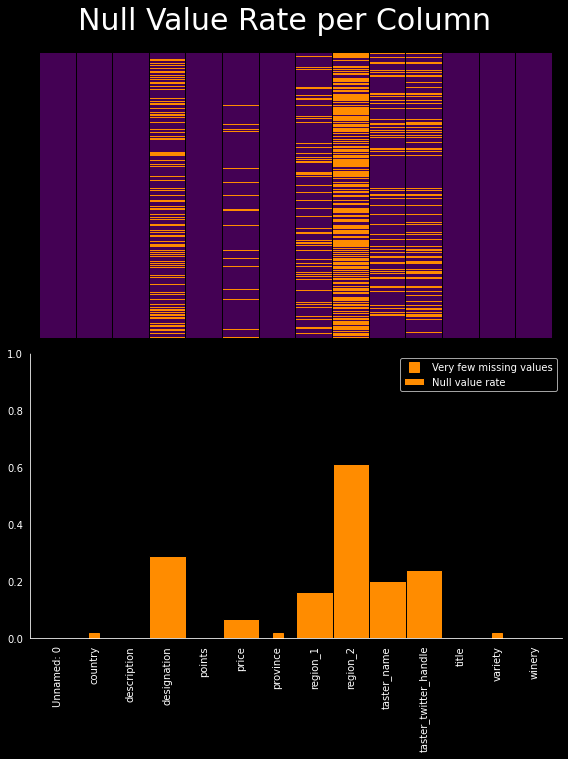

In [7]:
# NOTE: somehow, the heatmap of my dataset doesn't show the null value sin the columns 
# 'country', 'province' and 'variety'. Please help me to fix this.
def nullscan(df_check, save=False):
    '''
    df: a dataframe on which we want to perofrm the nullscan
    save: determines, whether you want to save the .png of the plot or not
    
    plots the rate of null values per column in a dataframe using 
    a seaborn heatmap and a barplot.
    '''    
    # a df with the same size of the original dataframe, containing True in cells containing NUll values.
    # and False in all the other cells.
    df_nulls = df_check.isna()
    # a series containing the sum of all values within a column having the column names as indices.
    # True is interpreted as 1 and False is interpreted as 0 
    nulls_per_col = df_nulls.sum(axis=0)
    # the rate makes it way more interpretable:
    nulls_per_col /= len(df_check.index)

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
    
        # ax1 is losely based on: https://www.kaggle.com/ipshitagh/wine-dataset-data-cleaning
        # NOTE: I could have used the cmap viridis or anything else instead, 
        # but I want to make clear that you can use any customized cmap as well.
        vir = matplotlib.cm.get_cmap('viridis')
        colormap = matplotlib.colors.ListedColormap([vir(0), 'darkorange'])
        sns.heatmap(df_check.isnull(), cmap=colormap, cbar=False, yticklabels=False, ax=ax1)
    
        nulls_per_col.plot(kind='bar', color='darkorange', x=nulls_per_col.values, 
                           y=nulls_per_col.index, ax=ax2, width=1, linewidth=1, 
                           edgecolor='black', align='edge', label='Null value rate')
        
        ax2.set_ylim((0,1))
        # centered labels
        labels=df_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
    
        # hide spines:
        # NOTE: I could have used ax2.set_frameon(False), 
        # but I wanted the bottom and the left spine to stay white.
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')
        
        
        
        # workaround to visualize very small amounts of null values per col
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='darkorange', markersize=10, 
                     label='Very few missing values')
    
        fig.suptitle('Null Value Rate per Column', fontsize=30, y=1.05)
        ax2.legend()
        fig.tight_layout() 
        if(save):
            plt.savefig('nullscan.png')
        plt.show()
nullscan(df)


Now that we know, that the dataset contains missing values, we have to decide how to handle them.

<a id="sec2"></a>
<h1 style="background-color:darkorange; color:black" >-> 2. Handle Missing Values</h1>


**There are some standard ways of handling these Null Values:**

* Drop rows containing a specified amount of Null Values. Use this method only, if the number of missing values within the respective row is very high. 


* Drop columns containing a specified amount of Null Values if the column isn't too relevant and the number of missing values is very high.


* Replace missing values with the column average. The most common value of a categorical feature and the median or the mean of a numerical feature can be interpreted as the average of the respective column.


* Replace the missing value with a predicted value. Therefore, one could use any Machine Learning Algorithm.


* Replace the missing values with zeros or 'Unknown' and treat it just like any other value if possible

Note: Replacing missing values is often called [imputation](https://scikit-learn.org/stable/modules/impute.html). If you impute many missing values in one column, it might improve the performance of your model if you create a binary flag column containing ones in all rows where you imputed a missing value.


Besides these standard methods, insights into the dataset and its context can reveal further suitable methods. Consider we have a dataset containing the email and the name of people. The *name* column contains missing values and the *email* column only contains values in rows having null values in the *name* column. It might be useful to fill the emails into the corresponding *name* cells in order to obtain an identifier for each person containing the *name* or at least the *email*.

<a id="sec3"></a>
<h1 style="background-color:darkorange; color:black" >-> 2.1. Drop rows</h1>


As we can see in the plot above, the columns 'country' and 'province' contain very few missing values. I want to show you how to drop the rows containing Null values in these columns. This method of handling Null values shouldn't be used too much, because we lose costly collected data. Hence, we should always consider if any other suitable methods could be applied instead if we are solving real-world problems.

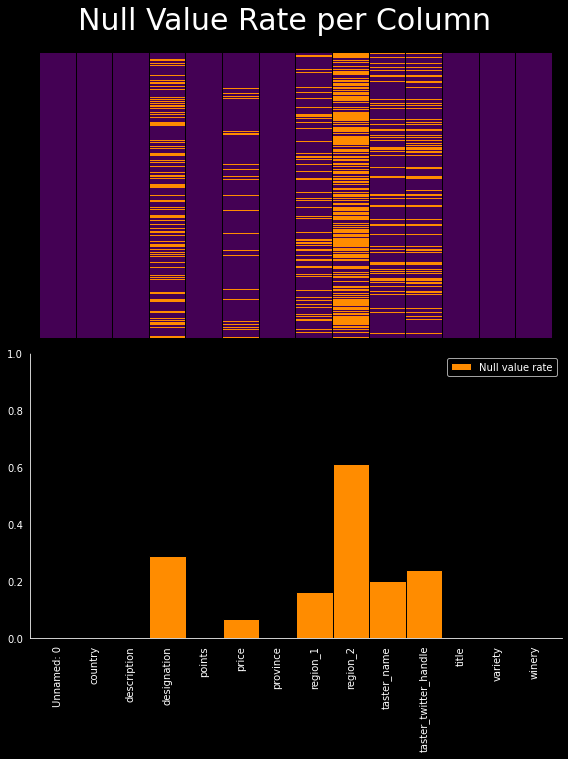

In [8]:
# drop all rows with Null values in 'country', 'province' OR 'variety':
df = df.dropna(subset=['country', 'province', 'variety'])

# one could even drop all rows containing 'too many' Null values:
# nrows_before = len(df.index)
# na_allowed = int(len(df.columns)/3)
# thresh = int(len(df.columns)) - na_allowed
# df = df.dropna(axis=0, thresh=thresh)
# nrows_afterwards = len(df.index)
nullscan(df, save=True)

<a id="sec4"></a>
<h1 style="background-color:darkorange; color:black" >-> 2.2. Drop Columns</h1>

Since the column 'region_2' contains many Null Values and it doesn't contain important information, we can simply drop the column.

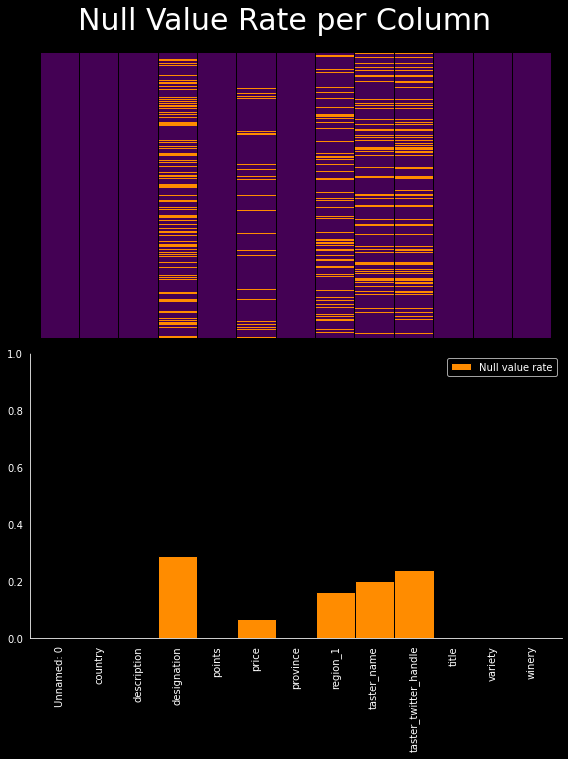

In [9]:
df = df.drop('region_2', axis=1)

nullscan(df)

<a id="sec5"></a>
<h1 style="background-color:darkorange; color:black" >-> 2.3. Replace Null values with 'Unknown' or 0</h1>


The column 'designation' has the second biggest amount of Missing Values. Let's take a look at the column.

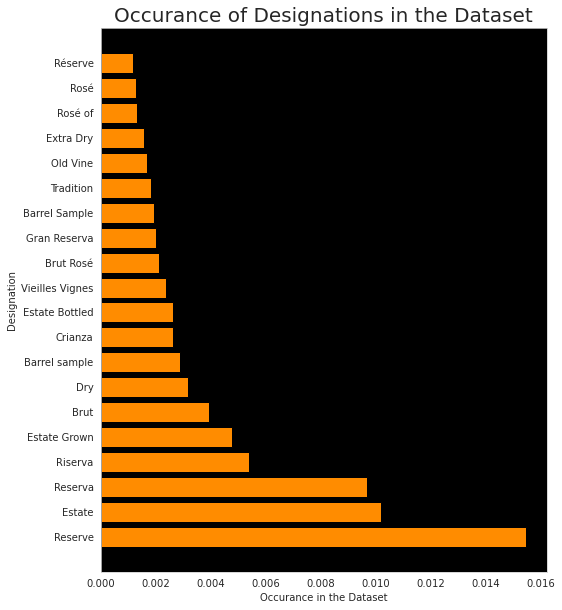

In [10]:
designation = df['designation'].value_counts().head(20) / len(df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), sharey=True)
ax.barh(y=designation.index, width=designation.values, color='darkorange', edgecolor='black')
ax.set_title('Occurance of Designations in the Dataset', fontsize=20)
ax.set_xlabel('Occurance in the Dataset')
ax.set_ylabel('Designation')
ax.set_facecolor('black')

Some values appear pretty often and it might be interesting to reveal any relationships between this feature and the other features. We shouldn't drop the column but replace the missing values with anything suitable. Unfortunately, the most common designation 'Reserve' is merely occurring in slightly more than 1% of the rows. Hence, we shouldn't replace the missing values with this most common value of the column.

Alternatively, I suggest replacing missing values with 'Unknown' and treat it like any other value. The same method can be applied to the column 'region_1'.

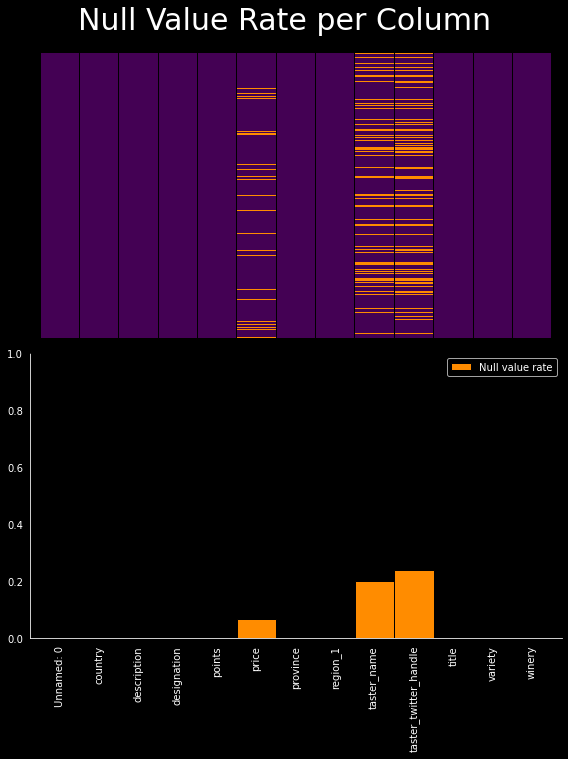

In [11]:
df[['designation', 'region_1']] = df[['designation', 'region_1']].fillna('Unknown')
nullscan(df)

To handle 'taster_name' and 'taster_twitter_handle', we have to get some insights into the relationship of the two variables. 

We know that both represent a reviewer and it might happen, that some reviewers are solely known by their name, and that some others are solely known by their Twitter handle. If so, we would have to find a way to merge these two columns into one column containing an identifier for the taster. To that end, we would prioritize the 'taster_name' to distinguish between the tasters from each other and fill the missing values in that column with the Twitter handle in the respective rows. Furthermore, it might happen that a single Twitter handle is used to review wines by multiple people or a single taster can have multiple Twitter handles.

**Let's see how often a taster name is given but a Twitter handle isn't:**

In [12]:
only_name = df.loc[df['taster_twitter_handle'].isnull() & df['taster_name'].notna(), 
                   ['taster_name', 'taster_twitter_handle']]
num_only_name = len(only_name.index)

only_twitter = df.loc[df['taster_name'].isnull() & df['taster_twitter_handle'].notna(), 
                      ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)

print(f'rows containing a name but no twitter handle: {num_only_name}'
      + f'\nrows containing a twitter handle but no taster name: {num_only_twitter}')

rows containing a name but no twitter handle: 4969
rows containing a twitter handle but no taster name: 0


Since tasters might review wines using multiple Twitter handles, and review differently using differing Twitter handles (e.g. if they delete their Twitter account and start reviewing wine on Twitter using a new account), we should scan if there are any tasters using multiple Twitter handles.

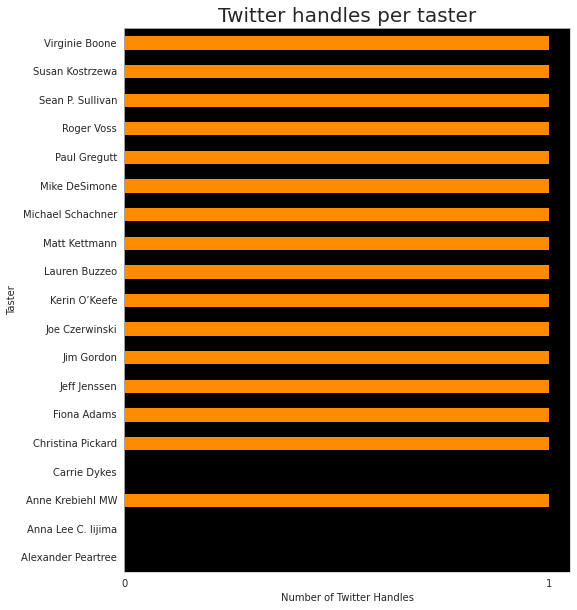

In [13]:
twitter_per_name = df.groupby('taster_name')['taster_twitter_handle'].nunique()
labels = twitter_per_name.index


fig, ax = plt.subplots(figsize=(8,10))
twitter_per_name.plot(kind='barh', ax=ax, color='darkorange', edgecolor='black')
ax.set_xticks([0,1])
ax.set_xlabel('Number of Twitter Handles')
ax.set_ylabel('Taster')
ax.set_title('Twitter handles per taster', fontsize=20)
ax.set_facecolor('black')

As shown above, each taster uses either one Twitter Handle or no Twitter handle at all. Thus, we can simply drop the column 'taster_twitter_handle'. It doesn't provide any  further information for our models. Moreover, we can replace the missing values in 'taster_name' with Unknown. 

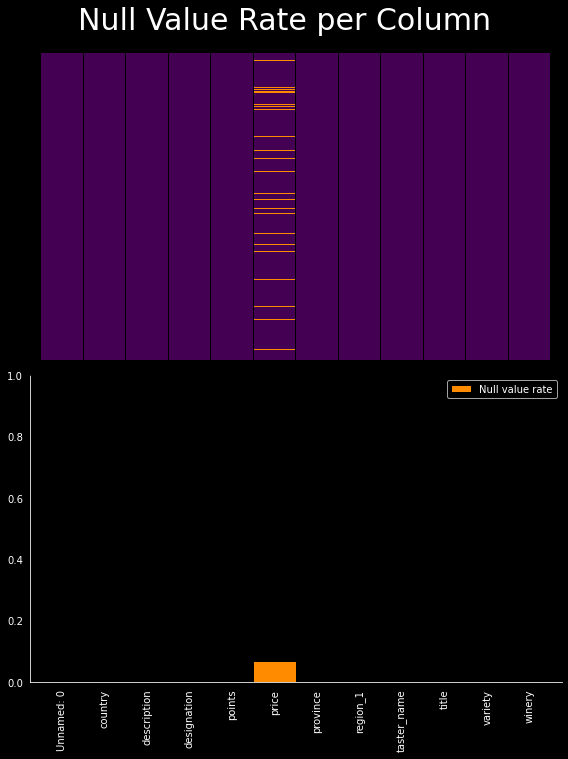

In [14]:
df = df.drop('taster_twitter_handle', axis=1)
df['taster_name'] = df['taster_name'].fillna('Unknown')
nullscan(df)

<a id="sec6"></a>
<h1 style="background-color:darkorange; color:black" >-> 2.4. Replace missing values with predicted values</h1>

The last column containing Null values is 'price'. We could easily replace missing values with the column mean. The advantage of this method would be, that the column means would stay the same, which might be important in later analysis steps. On the other hand, this method ( just like replacing missing values with the median of the column) is very unprecise and doesn't preserve the relationship between the respective feature and the other features.

I will give you a simple example of predicting the missing values using KNN. It will replace the missing price value with the median of the price values of the K nearest neighbors. Obviously, this method will most likely not reveal the real prices in all cases but will contain some residuals. At least, this method preserves the relationship between the used features. For simplicity, I will solely use the features 'points', 'country' and 'taster_name' to predict the missing values.

Since we want to predict prices, i.e. numerical values, we use a regression model (KNeighboursRegressor).

One advantage of using a KNN Regressor instead of any other regression model is that it (by definition) doesn't predict values that are out of the range from the already collected data observations (i.e. the training data). 

Info: The sklearn KNeighboursRegressor predicts the mean of the y-values of the K nearest neighbors, but in some cases, it might be more suitable to predict the median. Unfortunately, predicting the mean is hardcoded in sklearns KNeighboursRegressor (and for simplicity I will rely on sklearn in this tutorial).

Firstly, convert the categorical columns 'country' and 'taster_name' to indicator variables and store the training data and the data on which we want to predict the prices individually.

In [15]:
df_cleanup = df.loc[:, ['price', 'points', 'country', 'taster_name']]
encoded = pd.get_dummies(df_cleanup[['country', 'taster_name']], prefix=['country', 'taster_name'])
df_cleanup = pd.concat([df_cleanup.drop(['country', 'taster_name'], axis=1), encoded], axis=1)

# training data
df_cleanup_known = df_cleanup.loc[df_cleanup['price'].notnull(), :]
X_known = df_cleanup_known.drop('price', axis=1)
y_known = df_cleanup_known['price']

# prediction data
df_cleanup_unknown = df_cleanup.loc[df_cleanup['price'].isnull(), :]
X_unknown = df_cleanup_unknown.drop('price', axis=1)

Let's create the Regressor.

In [16]:
from sklearn.model_selection import GridSearchCV
knn_cleanup = KNeighborsRegressor()

# simple finetuning:
params = {'n_neighbors':[1,5,9]}
gs = GridSearchCV(knn_cleanup, params)
gs.fit(X_known, y_known)
knn_cleanup = gs.best_estimator_

Predict the prices and concatenate the data with already known prices and the data with predicted prices. 

Shuffle the result in order to ensure that the rows with predicted prices are not stored in a huge block.

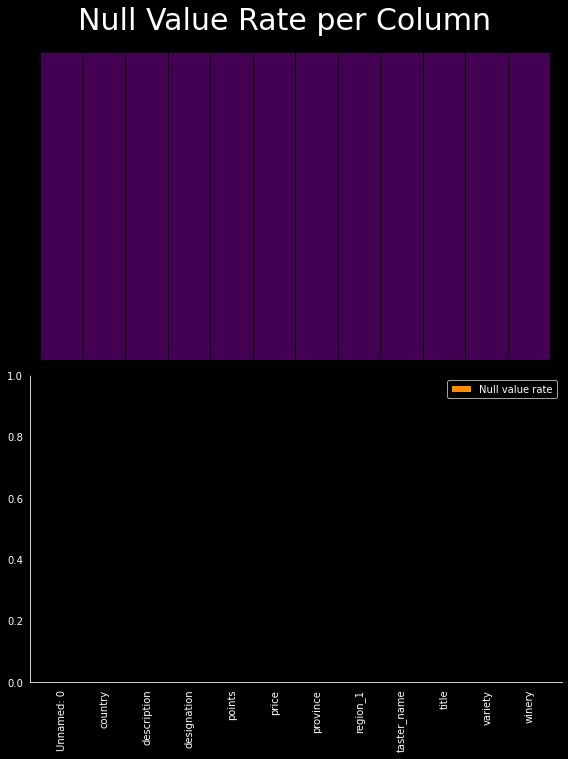

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
0,14964,New Zealand,The style of all the Craggy Range reds has evo...,Te Muna Road Vineyard,91,46.000000,Martinborough,Unknown,Joe Czerwinski,Craggy Range 2013 Te Muna Road Vineyard Pinot ...,Pinot Noir,Craggy Range
1,89138,US,"A compelling mix, with bright, vivacious fruit...",Artz Vineyard,89,18.000000,Washington,Red Mountain,Paul Gregutt,Woodinville Wine Cellars 2007 Artz Vineyard Sa...,Sauvignon Blanc,Woodinville Wine Cellars
2,71209,Austria,The vanilla and cookie-dough lick of toasty oa...,Reserve,90,22.666667,Carnuntum,Unknown,Anne Krebiehl MW,Markowitsch 2011 Reserve Pinot Noir (Carnuntum),Pinot Noir,Markowitsch
3,38896,France,"From a single parcel of old vines, this melon ...",Domaine des Grandes Esperances Le Roi Soleil,89,25.000000,Loire Valley,Touraine,Roger Voss,Saget la Perrière 2016 Domaine des Grandes Esp...,Sauvignon Blanc,Saget la Perrière
4,100666,France,"89-91 Barrel sample. A firm dry wine, its char...",Barrel sample,90,59.222222,Bordeaux,Sauternes,Roger Voss,Château de Rayne Vigneau 2008 Barrel sample (...,Bordeaux-style White Blend,Château de Rayne Vigneau


In [17]:
df_known = df.loc[df['price'].notnull(),:]
df_predicted = df.loc[df['price'].isnull(),:]

# to evade SettingWithCopyWarning
df_predicted = df_predicted.drop('price', axis=1)
df_predicted['price'] = knn_cleanup.predict(X_unknown)
df = pd.concat([df_known, df_predicted], axis=0, ignore_index=True)

# shuflle the dataset along rows
df = df.sample(frac=1).reset_index(drop=True)



nullscan(df)
df.head()

No missing values left!

<a id="sec61"></a>
<h1 style="background-color:darkorange; color:black" >-> 2.5. Attention! Hidden Missing Values</h1>

We got rid of all Null values, so we can already train a machine learning model on the data. But sometimes, missing values are not given in form of `None` or `NaN`. Let me give you an example. Let's take a look at the pima-indians diabetes dataset!

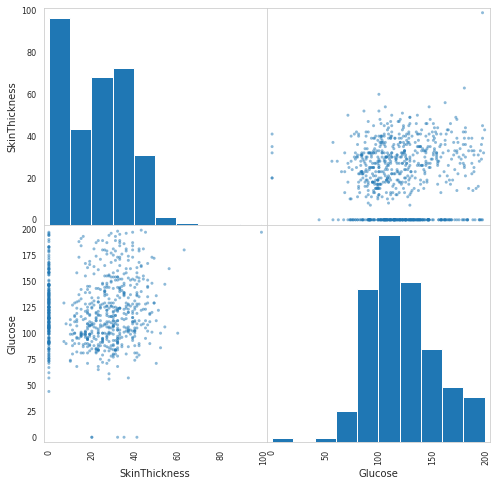

In [18]:
from pandas.plotting import scatter_matrix
data_diabetes = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')[['SkinThickness', 'Glucose']]
scatter_matrix(data_diabetes, figsize=(8,8));

Can you see these streaks at 0 ? They occure in more than just these two columns of this dataset. They most likely represent missing values in this dataset.
What I want to tell you is that you definitely have to take a look at your dataset. Plotting variables against each other may reveal interesting residuals from questionable preprocessing decisions which affected the data before you are abled to access the data.

<a id="sec7"></a>
<h1 style="background-color:darkorange; color:black" >-> 3. Handle Measurng Errors and Outliers</h1>


Measuring Errors and Outliers have a huge impact on the [Data Quality](#sec0):
* Consistency: A measuring error might lead to contradictory values (as described in [Section 0](#sec0))
* Accuracy: For obvious reasons, measuring errors might lead to values far away from the ground truth. Outliers distort "the big picture" and thus lead to a weakened accuracy concerning the whole population.

Sometimes, we can detect implicitely detect measuring errors by investigating outliers. E.g. if we have a dataset of student grades and each student can achieve between 0 and 10 points. If the dataset tells us that one student achieved more than 10 points, our dataset contains a measuring error and we have to determine how to handle this issue. In this case, the measuring error would most likely be an outlier as well, and we could detect it via outlier detection. 

Nevertheless, there might be some more measuring errors within our dataset, which aren't outliers, but in most cases, there is no **simple** way to detect these, as long as they match into the pattern of the data. We would have to treat them as noise. 

Data-points which are both, measuring errors and outliers, might be very harmful and have a huge impact on our model. 
Besides handling these harmful measuring errors, handling outliers might help our model to be even more powerful and we may want to handle them during [Feature Engineering](https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering/edit/run/45767292). Hence, we should definitely detect the outliers for multiple reasons.

But how do we detect outliers automatically? 
And how do we decide if these outliers are harmful?
Let us find out whether the numerical column 'price' contains outliers.

The probably most famous ways of detecting outliers are using the *z score* and visualizing the data using a *boxplot*.

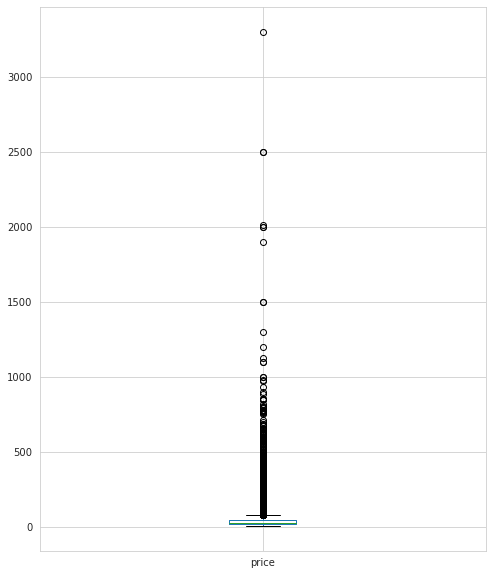

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))
df.boxplot(column='price', ax=ax1)
ax.set_title('Outliers in Price?');

I prefer using z-scores to detect `extreme` outliers only. Usually, outliers are defined as values having z-scores having an absolute value of 3. I prefer using a higher threshold of about 5 or 6:

In [20]:
from scipy import stats

# display all rows having outliers in 'price'
data = pd.DataFrame(df['price'])
data_zscore = data.apply(stats.zscore, axis=0)
mask_outliers = ((data_zscore>6).any(axis=1)).values + ((data_zscore<-6).any(axis=1)).values
data.loc[mask_outliers,:]

,price
651,309.666667
667,800.000000
698,325.000000
964,500.000000
1010,325.000000
...,...
128863,463.000000
129153,365.000000
129450,350.000000
129472,685.000000


As we can see, there are outliers in the respective column. Should we handle these as measuring errors?

This example shows us, that it isn't as easy to detect measuring errors as it is to detect missing values. One can simply determine whether a value is missing or not, but we need further information to determine whether a value is valid or not. 

I guess most of us wouldn't even think about buying a wine bottle that costs more than 200$, but every one of us knows that there are wines costing way more than a couple of hundred dollars per bottle, even though these wine bottles might not be found in the supermarket. Although expensive wines are rare, they still exist and thus we can't simply handle these data points as measuring errors. 

As you can see, boxplots might be useful, but in most cases, one needs to have some *domain knowledge* to determine whether one has to handle specific outliers separately as measuring errors or not. 

Anyways, if you are sure that you found some data-points which are measuring errors, you can treat them just like [Missing values](#sec1). And what about the outliers that are probably no errors? We should try to reduce their impact on our machine learning model during [Feature Engineering](https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering). if that's not working, we can still handle them as missing values.

<a id="sec8"></a>
<h1 style="background-color:darkorange; color:black" >-> 4. Change Measuring Units</h1>

To obtain [Uniformity](#sec0), we might have to bring values to a different unit. 

Unfortunately, it isn't always possible to determine, if one feature contains values, which were measured on the same scale. Further informations like notes from the data measuring process might be helpful. However, it might help to use a clustering algorithm to find out, if there are clusters with (context-based) extremely dissimilar mean values.

Let me give you an easy example using [k-means clustering](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1):

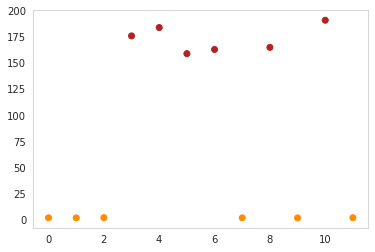

In [21]:
from sklearn.cluster import KMeans
height = np.array([1.74, 1.67, 1.87, 176, 184, 159, 163, 1.71, 165, 1.62, 191, 1.82])
np.size(height)

# use kmeans; try different number of clusters, if needed
cluster_kmeans = KMeans(n_clusters=2)
cluster_kmeans.fit(height.reshape((-1,1)))
# plot
colors = np.array(['darkorange', 'firebrick'])
plt.scatter(x=range(np.size(height)), y=height, c=colors[cluster_kmeans.labels_])
plt.show()

Taking a look at the plotted clusters, it might be obvious, that the data isn't measured on the same scale. If it is obvious or not might depend on the context.
Afterward, we can easily separate the clusters and bring them on the same scale:

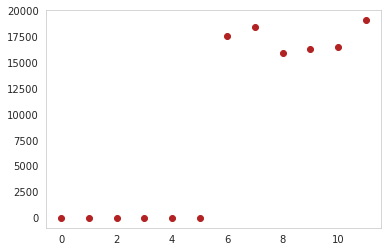

In [22]:
# separate the clusters
height_meter = height[cluster_kmeans.labels_ == 1]
height_cm = height[cluster_kmeans.labels_ == 0]
# bring them on a mutually equal scale
height_meter = height_meter * 100
# plot
height_transformed = np.append(height_cm, height_meter)
plt.scatter(x=range(np.size(height)), y=height_transformed, c='firebrick')
plt.show()

In simple cases like this, it might even be sufficient to take a look at the variance, since the variance of this feature should is pretty big, which indicates the data to contain very versatile values. 

However, in most cases, the best way to determine whether the data has differing scales within one feature is to refer to domain knowledge or notes from the data measuring procedure.

<a id="sec9"></a>
<h1 style="background-color:darkorange; color:black" >-> 5. Delete Duplicates</h1>

To obtain [Validity](#sec0), we have to ensure that the data fuflills a range of specifications. One very basic specification which has to be fulfilled in almost every case is that the data shouldn't contain any duplicates. 

Let's get ridd of all duplicates, if there are any..

In [23]:
# our data doesn't contain any duplicates
df.duplicated().sum()

0

So let#s create some data to give you an example..

In [24]:
dupli_values = np.array([[1,2],
                        [1,2],
                        [3,4],
                        [5,6],
                        [3,4]])

dupli_data = pd.DataFrame(data = dupli_values, columns=['a', 'b'])
dupli_data

,a,b
0,1,2
1,1,2
2,3,4
3,5,6
4,3,4


In [25]:
def remove_duplicates(data):
    dupli_con = pd.Series(range(len(data)))[data.duplicated() == False]
    return data.loc[dupli_con,:]
    
remove_duplicates(dupli_data)

,a,b
0,1,2
2,3,4
3,5,6


## That's it, thank you for reading my Notebook =)

I hope you learned a lot about cleaning your data and thereby improving its quality. 

Feel free to suggest further methods and ideas in the commetn section below!